**ENGY-4390** Nuclear Systems Design and Analysis, UMass Lowell, Chem. Eng. Nuclear Program Fall 2024; Prof. V. F. de Almeida

# Constant Thermal Conductivity, Inhomogeneous Source, and Dirichlet BC <br>
---

**Student(s):**  Kyle Mills and Billy Manco and Donaita Anglade <br>
**Course:** Engy-4390: Nuclear Systems Design and Analysis  <br>
**Mentor and Collaborator:** Subash Sharma

UMass Lowell, Dept. of Chemical Engineering, Nuclear Energy Program 
<br>
**21 Oct 2024**

---
## [Table of Contents](#toc)<a id="problem"></a>
* [Objectives](#Problem)
  + [Poisson Problem with Dirichelet BC](#Obj)
  + [Problem Data](#Data)
  + [Domain Set Up](#Domain) 
* [Test Three](#test)
  + [Poisson Problem Plot Results](#Results)
  + [Comparison to Gold Solution](#Comparison)
* [Conclusion](#Conclusion) 
---

## [Objectives](#toc)<a id="problem"></a>

+ Solve a 1-D heat conduction problem with an inhomogeneous source and known boundary temperatures.
+ Provide results to be used as a reference for other solutions 

## [Poisson Problem with Dirichlet Boundary Conditions](#toc)<a id="problem"></a>

The following sections describe a one-dimensional Poisson problem with Dirichlet boundary conditions. This is a classical boundary-value problem of mathematics.

Solve the Poisson model problem. Find $u:[a,b]\subset\Reals\rightarrow\Reals$ such that:

\begin{align*}
 -\bigl(-k(x)\, u'\bigr)'(x) + f(x) &= 0 \quad\quad \forall \quad\quad x\in\ ]a,b[, \\
 u(a) &= u_a, \\
 u(b) &= u_b.
\end{align*}
   
This problem is linear and has an analytical solution for given data: diffusion coefficient, $k(x)$, and Inhomogeneous source bias, $f(x)$. The *heat flux* associated to the quantity $u$, is denoted $q := -k(x)\,u'$, a derived quantity.

The values of the dependent variable are given on the two endpoints of the domain. This is called *essential* boundary conditions or  *Dirichlet boundary conditions*. If the values are equal to zero, the boundary condition is referred to as homogeneous.

## [Problem Data](#toc)<a id="setup"></a>

Heating power density, $f(x)$, is dependent on position, thermal conductivity, $k$, is a constant:

+ $k = 42 \left [ \frac{W}{mK} \right ]$
+ $f(x) = 206 151+129 400 \, x \; \left [ \frac{W}{m^{3}} \right ]$
+ $ a = 0 $ [cm]
+ $ b = 5 $ [cm]

and the temperature at the ends of the domain are specified as a Dirichlet BC:

+ $ T(a) = 20$ [°C], and $T(b)= 40$ [°C].


## [Setup of FEM](#toc)<a id="test"></a>

In [1]:
'''Domain'''
'''Rayleigh Ritz Method with Lagrange FE Basis Functions'''
x_min = 0     # m
x_max = 0.05  # m

degree = 2  # Degree of the lagrange polinomials used
n_elem = 10 # Number of elements used

In [2]:
'''Domain partition'''
from pyfires import get_domain_partition
'''Parent mapping'''
from pyfires import get_parent_mapping
'''The basis functions'''
from pyfires import get_parent_basis_functions
'''Global basis functions'''
from pyfires import global_basis_function
'''All global basis functions'''
from pyfires import get_global_basis_functions
'''Inner product'''
from pyfires import inner_product

## [Implementing Data](#toc)<a id="test"></a>

In [3]:
'''Thermal conductivity'''
from pyfires import linear_func
from pyfires import plot_func

k_func = linear_func(x_min, x_max, (42.0, 42.0)) # W/mK

'''Heating Power Density'''
f_func = linear_func(x_min, x_max, (4*206151.0, 4*212621.0)) # W/m^3

view_plots = False

In [4]:
if view_plots:
    n_plot_pts = 200
    title = 'Thermal Conductivity'
    xlabel = 'Position along the width of the channel wall [m]'
    ylabel = 'K [W/mk]'
    plot_func(k_func, x_min, x_max, n_plot_pts, title=title, xlabel=xlabel, ylabel=ylabel)

    title = 'Heating Power Density'
    xlabel = 'Position along the width of the channel wall [m]'
    ylabel = 'f [W/m^3]'
    plot_func(f_func, x_min, x_max, n_plot_pts, title=title, xlabel=xlabel, ylabel=ylabel)

In [5]:
'''FEM Solution'''
'''Domain partition'''

domain_partition = get_domain_partition(degree, n_elem, x_min, x_max)
parent_mapping = get_parent_mapping()
parent_basis_functions = get_parent_basis_functions()

phi_list = get_global_basis_functions(domain_partition, parent_mapping, parent_basis_functions, global_basis_function)[0]
phi_prime_list = get_global_basis_functions(domain_partition, parent_mapping, parent_basis_functions, global_basis_function)[1]

In [6]:
'''Building the lift function'''
u_a = 20 #temperature at point a in degrees C
u_b = 40 #temperature at point b in degrees C

lift_func = linear_func(x_min, x_max, (u_a, u_b)) # C
lift_prime = (u_b-u_a)/(x_max-x_min)
lift_func_prime = linear_func(x_min, x_max, (lift_prime, lift_prime)) # C

view_plots = False

In [7]:
if view_plots:
    n_plot_pts = 200
    title = 'Lift Function'
    xlabel = 'Position along the width of the channel wall [m]'
    ylabel = 'T [C]'
    plot_func(lift_func, x_min, x_max, n_plot_pts, title=title, xlabel=xlabel, ylabel=ylabel)

    title = 'Lift Function Prime'
    xlabel = 'Position along the width of the channel wall [m]'
    ylabel = 'dT/dx [C/m]'
    plot_func(lift_func_prime, x_min, x_max, n_plot_pts, title=title, xlabel=xlabel, ylabel=ylabel)

In [8]:
'''Build FEM A matrix'''
from pyfires import build_a_mtrx

a_mtrx = build_a_mtrx (phi_list, phi_prime_list, k_func, domain_partition, x_min, x_max, n_elem)

In [9]:
'''Buildload vector'''
from pyfires import build_b_vec

b_vec = build_b_vec (phi_list, phi_prime_list, k_func, f_func, lift_func_prime, domain_partition, x_min, x_max, n_elem)

### [Poisson Problem Plot Results](#toc)<a id = "Plot Results"></a>

In [10]:
'''Solution'''
'''Compute optimal coefficient vector'''

import numpy as np

c_star_vec = np.linalg.solve(a_mtrx, b_vec)

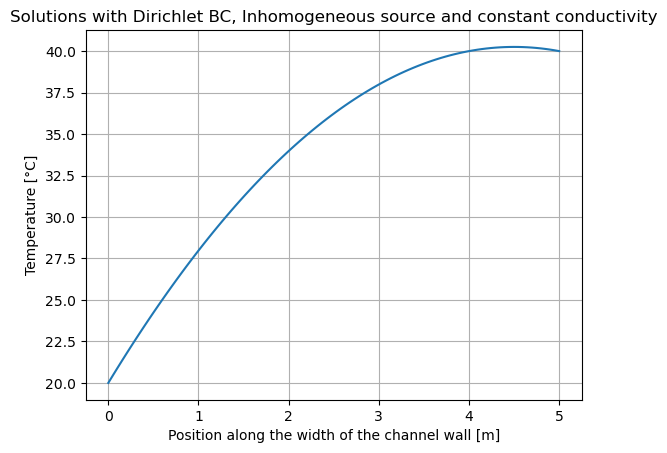

In [11]:
from pyfires import u_star

plot_func(lambda x: u_star(x, phi_list, lift_func, c_star_vec), x_min, x_max, 100,
          x_scale =100,
          title='Solutions with Dirichlet BC, Inhomogeneous source and constant conductivity',
         xlabel='Position along the width of the channel wall [m]',
           ylabel='Temperature [°C]')

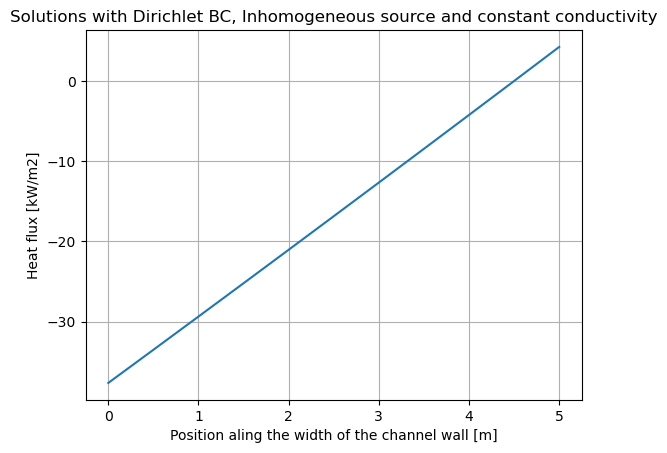

In [12]:
from pyfires import u_star_prime
h_e = (x_max-x_min)/n_elem
q_x = lambda x: - k_func(x) * u_star_prime(x, phi_prime_list, lift_func_prime, c_star_vec, h_e)
plot_func(q_x, x_min, x_max, 100, 
          x_scale=100, y_scale=1/1000,
          title='Solutions with Dirichlet BC, Inhomogeneous source and constant conductivity', 
          xlabel='Position aling the width of the channel wall [m]',
          ylabel='Heat flux [kW/m2]')

In [13]:
'''Normal heat flux at boundaries'''
n_x_a = -1.0
n_x_b =  1.0
print('q_n(a) [kW/m^2] = ', (q_x(x_min) * n_x_a)/1000) 
print('q_n(b) [kW/m^2] = ', (q_x(x_max) * n_x_b)/1000) 

q_n(a) [kW/m^2] =  [37.631845]
q_n(b) [kW/m^2] =  [4.245355]


### [Plot Result Comparison with Gold-Data](#toc)<a id = "Comparison"></a>

In [14]:
import numpy as np
(x,u,q) = np.loadtxt('gold-data/03-test-gold.txt')
u_gold = np.column_stack((x,u))

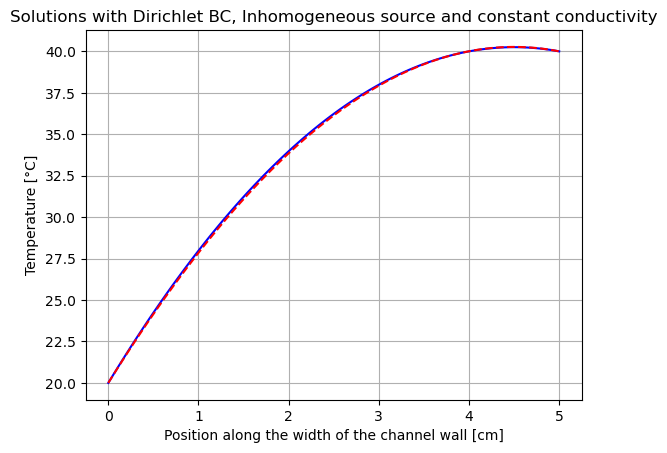

In [15]:
plot_func(lambda x: u_star(x, phi_list, lift_func, c_star_vec), x_min, x_max, 100,
          x_scale=100,
          title='Solutions with Dirichlet BC, Inhomogeneous source and constant conductivity', 
          xlabel='Position along the width of the channel wall [cm]',
          ylabel='Temperature [°C]', gold_data=u_gold)

In [16]:
import numpy as np
(x,u,q) = np.loadtxt('gold-data/03-test-gold.txt')
u_gold_3 = np.column_stack((x,q))

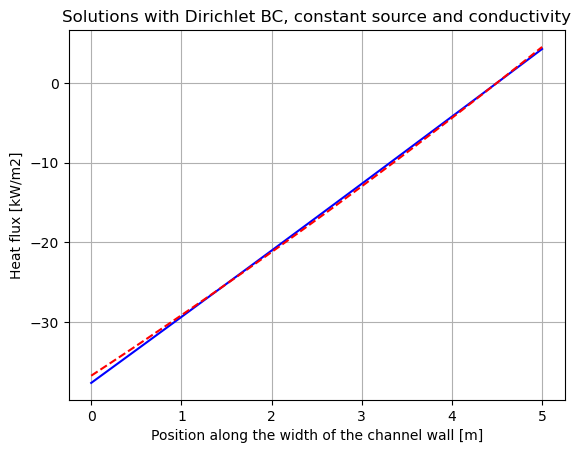

In [17]:
h_e = (x_max-x_min)/n_elem
q_x = lambda x: - k_func(x) * u_star_prime(x, phi_prime_list, lift_func_prime, c_star_vec, h_e)
plot_func(q_x, x_min, x_max, 100, 
          x_scale=100, y_scale=1/1000,
          title='Solutions with Dirichlet BC, constant source and conductivity', 
          xlabel='Position along the width of the channel wall [m]',
          ylabel='Heat flux [kW/m2]', gold_data = u_gold_3)

## [Conclusion](#toc)<a id = "Conclusion"></a>

The computed heat flux at 20 °C is 37.6 KW/m^2 and at 40 °C is 4.24 KW/m^2. These values are 36.7 KW/m^2 and 4.50 KW/m^2 at 20 °C and 40 °C, respectively, for the gold solution when the conditions are applied. As noticed, the higher the temperature, the lower the heat flux, proving that Magnesia is highly electrically insulative and has no shallow dopant options (not easily modified for electrical conductivity improvements).The theoretical heat flux at 20 °C is 32.6 KW/m^2 and at 40 °C is 3.24 KW/m^2 which are significantly less than the tested values, a possible source of error is the incorrect use of the resistivity formula 